# Modeling
___

## Load Libraries

In [ ]:
# !pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

# Import Models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import uniform


# Import Metrics
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, recall_score

## Read in Data

In [ ]:
## Import Train & Test Data
X_train = pd.read_csv('../Data/DataFrames/X_train.csv', index_col = 'Unnamed: 0')
X_test = pd.read_csv('../Data/DataFrames/X_test.csv', index_col = 'Unnamed: 0')
y_train = pd.read_csv('../Data/DataFrames/y_train.csv', index_col = 'Unnamed: 0')
y_test = pd.read_csv('../Data/DataFrames/y_test.csv', index_col = 'Unnamed: 0')

In [1]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape) 
print("y_train:", y_train.shape)
print("y_test:", y_test.shape) 

NameError: ignored

## Baseline values for y

In [ ]:
y_train.value_counts(normalize = True)

NOTE: Predict r/relationships, '0', with 52% accuracy.

## Logistic Regression Model

In [ ]:
with open('../Models/lgr.pkl', 'rb') as pickle_in:
    lgr = pickle.load(pickle_in)

/Users/kaitcrawford/opt/anaconda3/envs/dsi/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator StandardScaler from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kaitcrawford/opt/anaconda3/envs/dsi/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/kaitcrawford/opt/anaconda3/envs/dsi/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator Pipeline from version 1.0.2 when using ve

### Model Fitting

In [ ]:
lgr_pipe = Pipeline(steps=[
    ("ss", StandardScaler()), 
    ("lgr",  LogisticRegression(max_iter=1000, random_state=42))
])

In [ ]:
lgr_pipe.fit(X_train, y_train)

In [ ]:
# Export Model
with open('../Data/lgr.pkl', 'wb') as pickle_out:
    pickle.dump(lgr_pipe, pickle_out)

In [ ]:
print('Parameters currently in use:\n')
print(lgr_pipe.get_params())

Parameters currently in use:

{'memory': None, 'steps': [('ss', StandardScaler()), ('lgr', LogisticRegression(max_iter=1000, random_state=42))], 'verbose': False, 'ss': StandardScaler(), 'lgr': LogisticRegression(max_iter=1000, random_state=42), 'ss__copy': True, 'ss__with_mean': True, 'ss__with_std': True, 'lgr__C': 1.0, 'lgr__class_weight': None, 'lgr__dual': False, 'lgr__fit_intercept': True, 'lgr__intercept_scaling': 1, 'lgr__l1_ratio': None, 'lgr__max_iter': 1000, 'lgr__multi_class': 'auto', 'lgr__n_jobs': None, 'lgr__penalty': 'l2', 'lgr__random_state': 42, 'lgr__solver': 'lbfgs', 'lgr__tol': 0.0001, 'lgr__verbose': 0, 'lgr__warm_start': False}


### Metrics

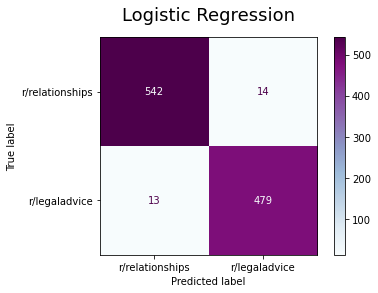

In [ ]:
ConfusionMatrixDisplay.from_estimator(lgr_pipe, X_test, y_test, cmap = "BuPu", 
                                      display_labels = ["r/relationships", "r/legaladvice"])
plt.title("Logistic Regression", fontdict={"fontsize": 18}, y = 1.05)
plt.savefig('../Visualizations/matrix_lgr.png', bbox_inches='tight');

Adapted from: https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format

## Bayes Search with SVC

In [ ]:
with open('../Models/svc_bayes.pkl', 'rb') as pickle_in:
    svc_bayes = pickle.load(pickle_in)

/Users/kaitcrawford/opt/anaconda3/envs/dsi/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator SVC from version 1.0.2 when using version 1.1.3. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/var/folders/7l/441dnk_52sgfldpwf_5_7dmr0000gn/T/ipykernel_81519/3614645353.py:2: DeprecationWarning: Please use `OptimizeResult` from the `scipy.optimize` namespace, the `scipy.optimize.optimize` namespace is deprecated.
  svc_bayes = pickle.load(pickle_in)


### Parameters
(Source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html retrieved on Dec 4, 2022)

In [ ]:
bayes_spaces = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'degree': Integer(1,8),
    'kernel': Categorical(['linear', 'poly', 'rbf']),
}

### Model Fitting

(Source: https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html retrieved on Dec 4, 2022)

In [ ]:
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.fit_transform(X_test)

In [ ]:
svc_bayes = BayesSearchCV(
    estimator = SVC(random_state=42), 
    search_spaces = bayes_spaces, 
    n_iter = 20, 
    cv = 5, 
    verbose=2, 
    random_state=42, 
    n_jobs = -1
)

In [1]:
svc_bayes.fit(X_train_scaled, y_train)

In [ ]:
with open('../Data/svc_bayes.pkl', 'wb') as pickle_out:
    pickle.dump(svc_bayes, pickle_out)

In [ ]:
svc_bayes.best_params_

In [ ]:
svc_bayes.best_estimator_

### Metrics

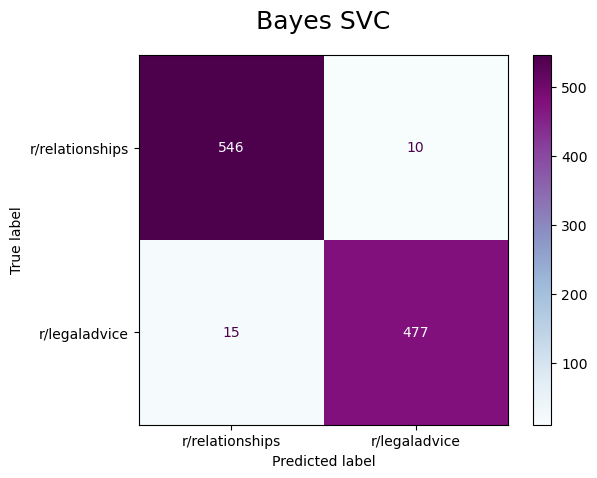

In [ ]:
ConfusionMatrixDisplay.from_estimator(svc_bayes, X_test_scaled, y_test, cmap = "BuPu", 
                                      display_labels = ["r/relationships", "r/legaladvice"])
plt.title("Bayes SVC", fontdict={"fontsize": 18}, y = 1.05)
plt.savefig('../Visualizations/matrix_lgr_bayes.png', bbox_inches='tight');

## Evaluating Model Performances

In [ ]:
print(classification_report(y_test, lgr.predict(X_test_scaled), target_names=['r/relationships', 'r/legal'], digits=3))

                 precision    recall  f1-score   support

r/relationships      0.888     0.883     0.885       556
        r/legal      0.869     0.874     0.871       492

       accuracy                          0.879      1048
      macro avg      0.878     0.879     0.878      1048
   weighted avg      0.879     0.879     0.879      1048



/Users/kaitcrawford/opt/anaconda3/envs/dsi/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [ ]:
print(classification_report(y_test, svc_bayes.predict(X_test_scaled), target_names=['r/relationships', 'r/legal'], digits=3))

                 precision    recall  f1-score   support

r/relationships      0.973     0.982     0.978       556
        r/legal      0.979     0.970     0.974       492

       accuracy                          0.976      1048
      macro avg      0.976     0.976     0.976      1048
   weighted avg      0.976     0.976     0.976      1048

